In [1]:
from Pipelines.process import *
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, GAM, s, f, te, l
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import math
import numpy as np

In [2]:
df_1 = process_raw("../test.csv").pipe(take_difference).pipe(take_population_rates).pipe(imputation_waves)

Checking whether there is an H2O instance running at http://localhost:8888 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_251"; Java(TM) SE Runtime Environment (build 1.8.0_251-b08); Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from /Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp6gf6xc_8
  JVM stdout: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp6gf6xc_8/h2o_azizbenmosbah_started_from_python.out
  JVM stderr: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp6gf6xc_8/h2o_azizbenmosbah_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_azizbenmosbah_b8nxs2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,177.8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [HIPASS J1247-77, Leo V Dwarf]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [HIPASS J1247-77, Hercules Dwarf, Leo V Dwarf]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230), UGCA 438 (ESO 407-018)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XIX[60], Andromeda XVIII[60], KKR 03 (KK98 230), UGCA 438 (ESO 407-018)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230), KUG 1210+301B (KK98 127)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XVIII[60], KKR 03 (KK98 230), KUG 1210+301B (KK98 127)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XVII, KKR 03 (KK98 230), Leo V Dwarf, Maffei 2, NGC 247, NGC 4214 (UGC 7278), Pegasus III, UGCA 15 (DDO 6), UGCA 276 (DDO 113)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XVII, Andromeda XVIII[60], KKR 03 (KK98 230), Leo V Dwarf, Maffei 2, NGC 247, NGC 4214 (UGC 7278), Pegasus III, UGCA 15 (DDO 6), UGCA 276 (DDO 113)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), KKR 03 (KK98 230)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XVIII[60], KKR 03 (KK98 230)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), ESO 383-087 (ISG 39), ESO 540-030 (KDG 2), HIPASS J1247-77, Holmberg II (DDO 50, UGC 4305), IC 342, KKR 03 (KK98 230), NGC 4214 (UGC 7278), Pegasus III, Sextans A (92205, DDO 75), Tucana II, UGC 8651 (DDO 181), UGCA 15 (DDO 6), UGCA 438 (ESO 407-018), UGCA 86]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XII, Andromeda XIX[60], Andromeda XVIII[60], ESO 383-087 (ISG 39), ESO 540-030 (KDG 2), HIPASS J1247-77, Hercules Dwarf, Holmberg II (DDO 50, UGC 4305), IC 342, KKR 03 (KK98 230), NGC 4214 (UGC 7278), Pegasus III, Sextans A (92205, DDO 75), Tucana II, UGC 8651 (DDO 181), UGCA 15 (DDO 6), UGCA 438 (ESO 407-018), UGCA 86]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [ESO 383-087 (ISG 39), Eridanus II, IC 342, NGC 4214 (UGC 7278), UGCA 86]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XII, Andromeda XVIII[60], ESO 383-087 (ISG 39), Eridanus II, IC 342, NGC 4214 (UGC 7278), UGCA 86]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XVII]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XVII, Andromeda XVIII[60]]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [ESO 383-087 (ISG 39), Eridanus II, IC 342, UGCA 86]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [UGCA 438 (ESO 407-018), Ursa Minor Dwarf]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda X, Andromeda XVII, Carina Dwarf (E206-G220), ESO 410-G005, IC 1613 (UGC 668), KKR 03 (KK98 230), KKR 25, Leo V Dwarf, Maffei 2, NGC 247, Pegasus III, Reticulum III, UGC 8651 (DDO 181), UGC 8833, UGCA 15 (DDO 6), UGCA 276 (DDO 113)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda X, Andromeda XVII, Andromeda XVIII[60], Carina Dwarf (E206-G220), ESO 410-G005, IC 1613 (UGC 668), KKR 03 (KK98 230), KKR 25, Leo V Dwarf, Maffei 2, NGC 247, Pegasus III, Reticulum III, UGC 8651 (DDO 181), UGC 8833, UGCA 15 (DDO 6), UGCA 276 (DDO 113)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XV, Andromeda XXVIII, Antlia 2, Camelopardalis B, Cassiopeia III (Andromeda XXXII), Cetus Dwarf, Draco II, Dwingeloo 1, ESO 383-087 (ISG 39), Eridanus II, FM2000 1, HIPASS J1247-77, Holmberg II (DDO 50, UGC 4305), KK98 35, KKR 03 (KK98 230), Large Magellanic Cloud (LMC), Leo T Dwarf, M32 (NGC 221), Maffei 2, NGC 2403, NGC 247, NGC 3741, NGC 4163 (NGC 4167), NGC 4214 (UGC 7278), NGC 5102, NGC 5237, NGC 55, Pegasus Dwarf Sph (And VI), Phoenix II, Pictor II, Sculptor Dwarf (E351-G30), Tucana II, UGC 8833, UGCA 105, UGCA 15 (DDO 6), UGCA 276 (DDO 113), UGCA 438 (ESO 407-018), UGCA 86, Ursa Minor Dwarf]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XII, Andromeda XIX[60], Andromeda XV, Andromeda XVIII[60], Andromeda XXII[57], Andromeda XXVIII, Antlia 2, Camelopardalis B, Cassiopeia III (Andromeda XXXII), Cetus Dwarf, Draco II, Dwingeloo 1, ESO 383-087 (ISG 39), Eridanus II, FM2000 1, HIPASS J1247-77, Holmberg II (DDO 50, UGC 4305), KK98 35, KKR 03 (KK98 230), Large Magellanic Cloud (LMC), Leo T Dwarf, M32 (NGC 221), Maffei 2, NGC 2403, NGC 247, NGC 3741, NGC 4163 (NGC 4167), NGC 4214 (UGC 7278), NGC 5102, NGC 5237, NGC 55, Pegasus Dwarf Sph (And VI), Phoenix II, Pictor II, Sculptor Dwarf (E351-G30), Triangulum Galaxy (M33), Tucana II, UGC 8833, UGCA 105, UGCA 15 (DDO 6), UGCA 276 (DDO 113), UGCA 438 (ESO 407-018), UGCA 86, Ursa Minor Dwarf]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Hercules Dwarf]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), KKR 03 (KK98 230)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XVIII[60], KKR 03 (KK98 230)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XVIII[60]]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XI, Andromeda XXIX, ESO 540-030 (KDG 2), HIPASS J1247-77, Holmberg II (DDO 50, UGC 4305), KUG 1210+301B (KK98 127), Large Magellanic Cloud (LMC), Leo I Dwarf (DDO 74, UGC 5470), Leo V Dwarf, Pegasus III, Pisces III (Andromeda XIII), Pisces V (Andromeda XVI), Reticulum III, Sextans B (UGC 5373), UGC 8651 (DDO 181), UGCA 15 (DDO 6), Virgo I]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XI, Andromeda XVIII[60], Andromeda XXIX, ESO 540-030 (KDG 2), HIPASS J1247-77, Hercules Dwarf, Holmberg II (DDO 50, UGC 4305), KUG 1210+301B (KK98 127), Large Magellanic Cloud (LMC), Leo I Dwarf (DDO 74, UGC 5470), Leo V Dwarf, Pegasus III, Pisces III (Andromeda XIII), Pisces V (Andromeda XVI), Reticulum III, Sextans B (UGC 5373), UGC 8651 (DDO 181), UGCA 15 (DDO 6), Virgo I]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Sextans A (92205, DDO 75), UGC 8651 (DDO 181), UGCA 438 (ESO 407-018)]
  warnings.warn(w)


gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XI, ESO 383-087 (ISG 39), Eridanus II, IC 342, KKh 086, NGC 4214 (UGC 7278), UGCA 86]
  warnings.warn(w)


drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda XI, Andromeda XII, Andromeda XVIII[60], ESO 383-087 (ISG 39), Eridanus II, IC 342, KKh 086, NGC 4214 (UGC 7278), UGCA 86]
  warnings.warn(w)


H2O session _sid_a97e closed.


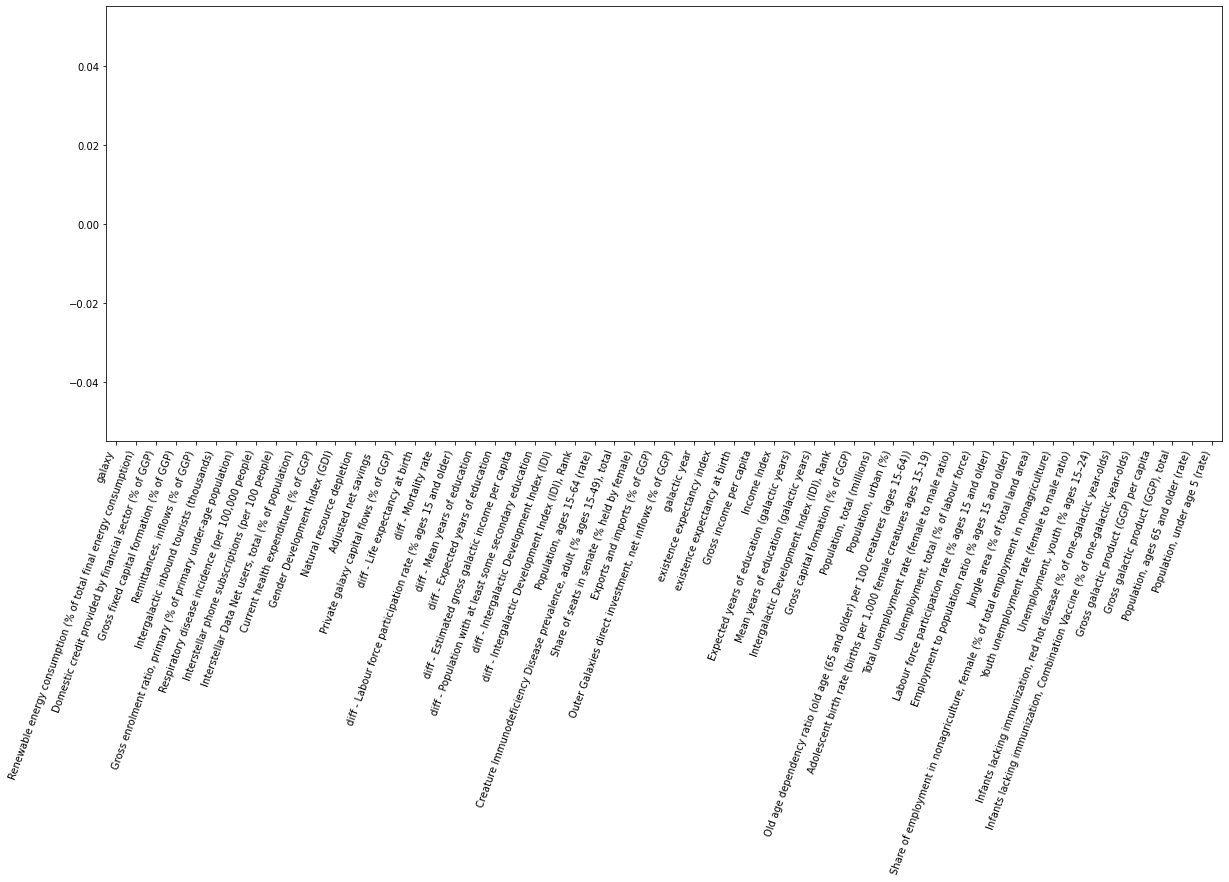

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
ser = (df_1.isnull().sum(axis=0) / len(df_1)).sort_values()
ax = ser.plot.bar(rot = 0)
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
plt.show()

In [12]:
df_1[df_1['existence expectancy index'].isna()]

,galaxy,galactic year,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),"Intergalactic Development Index (IDI), Rank",Gross capital formation (% of GGP),...,diff - Labour force participation rate (% ages 15 and older),diff - Mean years of education,diff - Expected years of education,diff - Estimated gross galactic income per capita,diff - Population with at least some secondary education,diff - Intergalactic Development Index (IDI),"diff - Intergalactic Development Index (IDI), Rank","Population, ages 15–64 (rate)","Population, ages 65 and older (rate)","Population, under age 5 (rate)"


In [10]:
from sklearn.impute import SimpleImputer
def last_imputation(df):
    
    for galaxy in df.galaxy.unique():
        data = df.loc[df.galaxy == galaxy,df.columns!='galaxy']
        imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(data)
        df.loc[df.galaxy == galaxy, df.columns!='galaxy'] = imp.transform(data)
        
    return df

In [11]:
df_1 = df_1.pipe(last_imputation)

In [6]:
features = ['galaxy', 'galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Population, urban (%)',
       'Unemployment, youth (% ages 15–24)',
       'Unemployment, total (% of labour force)',
       'Adolescent birth rate (births per 1,000 female creatures ages 15-19)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Renewable energy consumption (% of total final energy consumption)',
       'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)',
       'Gross galactic product (GGP) per capita', 'Income Index',
       'Gross income per capita',
       'Infants lacking immunization, red hot disease (% of one-galactic year-olds)',
       'Respiratory disease incidence (per 100,000 people)',
       'Domestic credit provided by financial sector (% of GGP)',
       'Interstellar Data Net users, total (% of population)',
       'Natural resource depletion', 'Adjusted net savings ',
       'Gross capital formation (% of GGP)',
       'Intergalactic Development Index (IDI), Rank',
       'Mean years of education (galactic years)',
       'Expected years of education (galactic years)',
       'Gender Development Index (GDI)']



targets = [ 
       'Population, under age 5 (rate)',
       'Population, ages 65 and older (rate)', 
    
       'diff - Labour force participation rate (% ages 15 and older)', # >10%, H20GBM
       'Labour force participation rate (% ages 15 and older)',# >20%, H20GBM
       'Employment to population ratio (% ages 15 and older)',# >20% H20GBM
       'Share of employment in nonagriculture, female (% of total employment in nonagriculture)',#10%, H20GBM
       'Interstellar phone subscriptions (per 100 people)', #>10% H2oGB
       'Private galaxy capital flows (% of GGP)', #>10% H2oGB
    
       'Gross fixed capital formation (% of GGP)' #>20%, H20RF
    
       'Current health expenditure (% of GGP)', #>10% H2oGB
       ]

RF_targets = ['Remittances, inflows (% of GGP)','Youth unemployment rate (female to male ratio)']



In [71]:
from pygam import LinearGAM, GAM, s, f, te, l
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV

In [72]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [76]:
h2o.shutdown()

/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_a4af closed.


In [77]:
df_predicted = df_1.copy()
RMSE_list = []
h2o.init()
h2o.cluster().show_status()

for TARGET in targets:

    df_predictors = df_predicted.loc[:,  features + [TARGET]]
    
    df_predictors = df_predictors.dropna()
    
    h2o_df = h2o.H2OFrame(df_predictors)

    train, test = h2o_df.split_frame(ratios=[.8], seed=1234)
    
    
    predictors = features
    
    response = TARGET
    
    hyper_params_tune = {
            'max_depth' : list(range(5,60,1)),
            'nbins': [2**x for x in range(4,9)],
            'nbins_cats': [2**x for x in range(4,9)],
            'ntrees': [100,200,400,800, 1000],
            'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
    
    search_criteria_tune = {'strategy': "RandomDiscrete",
                       'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                       'max_models': 100,  ## build no more than 100 models
                       'seed' : 1234,
                       'stopping_rounds' : 5,
                       'stopping_metric' : "rmse",
                       'stopping_tolerance': 1e-3
                       }
    
    rf_v1 = H2ORandomForestEstimator(model_id="rf_covType_v1")
    

    h2orf = H2OGridSearch(rf_v1, grid_id='gbm_.{0}'.format(TARGET), hyper_params=hyper_params_tune,
                           search_criteria = search_criteria_tune)

    h2orf.train(x=predictors, y=response, training_frame=train, seed=1111)
    
    
    rf_gridperf1 = h2orf.get_grid(sort_by='mse', decreasing=False)
    
    
    bestrf = rf_gridperf1.models[0]

    rmse = bestrf.model_performance(test).rmse()
    print('RMSE for {0}: {1}'.format(TARGET,rmse))
    RMSE_list.append(rmse)
    h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_251"; Java(TM) SE Runtime Environment (build 1.8.0_251-b08); Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from /Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp5jhk05ms
  JVM stdout: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp5jhk05ms/h2o_azizbenmosbah_started_from_python.out
  JVM stderr: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmp5jhk05ms/h2o_azizbenmosbah_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_azizbenmosbah_z3zftw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_azizbenmosbah_z3zftw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for Population, total (millions): 279.3102164658498
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for diff - Life expectancy at birth: 4.767764146911866
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for Population, ages 15–64 (rate): 1.022957792789197
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
RMSE for Population, under age 5 (rate): 0.22041148339667951
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |█████████

In [ ]:
df_predicted = df_1.copy()

h2o.init()
h2o.cluster().show_status()

for TARGET in targets:

    df_predictors = df_predicted.loc[:,  features + [TARGET]]
    
    df_predictors = df_predictors.dropna()
    
    h2o_df = h2o.H2OFrame(df_predictors)

    train, test = h2o_df.split_frame(ratios=[.8], seed=1234)
    
    
    predictors = features
    
    response = TARGET
    
    hyper_params_tune = {'max_depth' : list(range(1,21,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [1,2,4,8,16,25],
                'nbins': [2**x for x in range(4,9)],
                'nbins_cats': [2**x for x in range(4,9)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
    
    search_criteria_tune = {'strategy': "RandomDiscrete",
                       'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                       'max_models': 100,  ## build no more than 100 models
                       'seed' : 1234,
                       'stopping_rounds' : 5,
                       'stopping_metric' : "rmse",
                       'stopping_tolerance': 1e-3
                       }
    
    
  
    h2ogbm = H2OGradientBoostingEstimator(nfolds=5,
                                         learn_rate=0.05,
                                         learn_rate_annealing = 0.99,
                                         score_tree_interval = 10, 
                                         stopping_rounds = 5,
                                         stopping_metric = "rmse",
                                         stopping_tolerance = 1e-4,
                                         ntrees= 1000,
                                         seed=1111,
                                         keep_cross_validation_predictions = True,
                                         distribution ='gaussian')
    

    

    h2ogbm = H2OGridSearch(h2ogbm, grid_id='gbm_.{0}'.format(TARGET), hyper_params=hyper_params_tune,
                           search_criteria = search_criteria_tune)

    h2ogbm.train(x=predictors, y=response, training_frame=train, seed=1111)
    
    
    gbm_gridperf1 = h2ogbm.get_grid(sort_by='mse', decreasing=False)
    
    
    bestgbm = gbm_gridperf1.models[0]

    rmse = bestgbm.model_performance(test).rmse()
    print('RMSE for {0}: {1}'.format(TARGET,rmse))
    #RMSE_list.append(rmse)
    h2o.remove_all()


In [1]:
df_reg_2 = df_1.copy()
df_predicted = df_1.copy()
RMSE_list = []
i=0
for TARGET in RF_targets:

    df_predictors = df_predicted.loc[:, features + [TARGET]]
    
    df_predictors = df_predictors.dropna()
    df_predictors = pd.get_dummies(df_predictors)
    df_predictors = df_predictors.dropna()
    X_train, X_test, y_train, y_test = train_test_split(df_predictors.loc[:, ((df_predictors.columns != TARGET) & (df_predictors.columns != 'galaxy'))], df_predictors[TARGET], test_size=0.33, random_state=42)
    
    if (i == 0):
        param_grid = {#'bootstrap': [True, False],
                     'max_depth': [25, 30, 35],
                     'max_features': ['sqrt'],
                     #'min_samples_leaf': [1, 2, 4],
                     #'min_samples_split': [2, 5, 10],
                     'n_estimators': [800,1000,1200]}
    else:
        param_grid = {#'bootstrap': [True, False],
                     'max_depth': [40,50,60,79],
                     'max_features': ['sqrt'],
                     #'min_samples_leaf': [1, 2, 4],
                     #'min_samples_split': [2, 5, 10],
                     'n_estimators': [800]}
    
    regr = RandomForestRegressor(random_state=0)
    
    
    clf = GridSearchCV(regr, param_grid)
    clf.fit(X_train, y_train)
    
    
    print(clf.best_params_)
    print('RMSE for {0}: {1}'.format(TARGET,sqrt(mean_squared_error(y_test, clf.predict(X_test)))))
    RMSE_list.append(sqrt(mean_squared_error(y_test, clf.predict(X_test))))
    i = i+1

#RMSE_df['Default_RF'] = RMSE_list

NameError: name 'df_1' is not defined